### Imports

In [102]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.decomposition import PCA

### Load dataset

In [103]:
# --- data ---
train_data = np.load("dataset.npz")
X, y = train_data["X"], train_data["y"]
Xc = np.load("dataset_corrupted.npz")["X"] # corrupted data

print("Train:", X.shape, "Labels:", y.shape)
print("Corrupt:", Xc.shape)


Train: (13067, 400) Labels: (13067,)
Corrupt: (405, 400)


In [104]:
# Placeholder model 
X_tr, X_va, y_tr, y_va = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)
clf = RandomForestClassifier(n_estimators=400, max_features="sqrt", n_jobs=-1, random_state=42)
clf.fit(X_tr, y_tr)

,n_estimators,400
,criterion,'gini'
,max_depth,None
,min_samples_split,2
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0
,max_features,'sqrt'
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,bootstrap,True
,oob_score,False


In [105]:
# --- usikkerhet ---
probs = clf.predict_proba(Xc)
conf  = probs.max(axis=1)
unc   = 1.0 - conf

# --- PCA-rekonstruksjon (tren på rene X) ---
n_components = 10
pca = PCA(n_components=n_components, random_state=42).fit(X)
Xc_rec = pca.inverse_transform(pca.transform(Xc))
re = np.mean((Xc - Xc_rec)**2, axis=1)
re = np.log1p(re)
re_n = (re - re.min()) / (re.max() - re.min() + 1e-8)

# --- score = vektet kombinasjon ---
alpha = 0.7
score = alpha*unc + (1-alpha)*re_n

# --- terskel ---
P = 78  # 89 ≈ 22%
thr = np.percentile(score, P)
suspect_idx = np.where(score >= thr)[0]
print(f"Flagged: {len(suspect_idx)} / {len(Xc)} ({100*len(suspect_idx)/len(Xc):.1f}%), thr={thr:.3f}, alpha={alpha}, P={P}, n_components={n_components}")


Flagged: 89 / 405 (22.0%), thr=0.788, alpha=0.7, P=78, n_components=10


## Plot

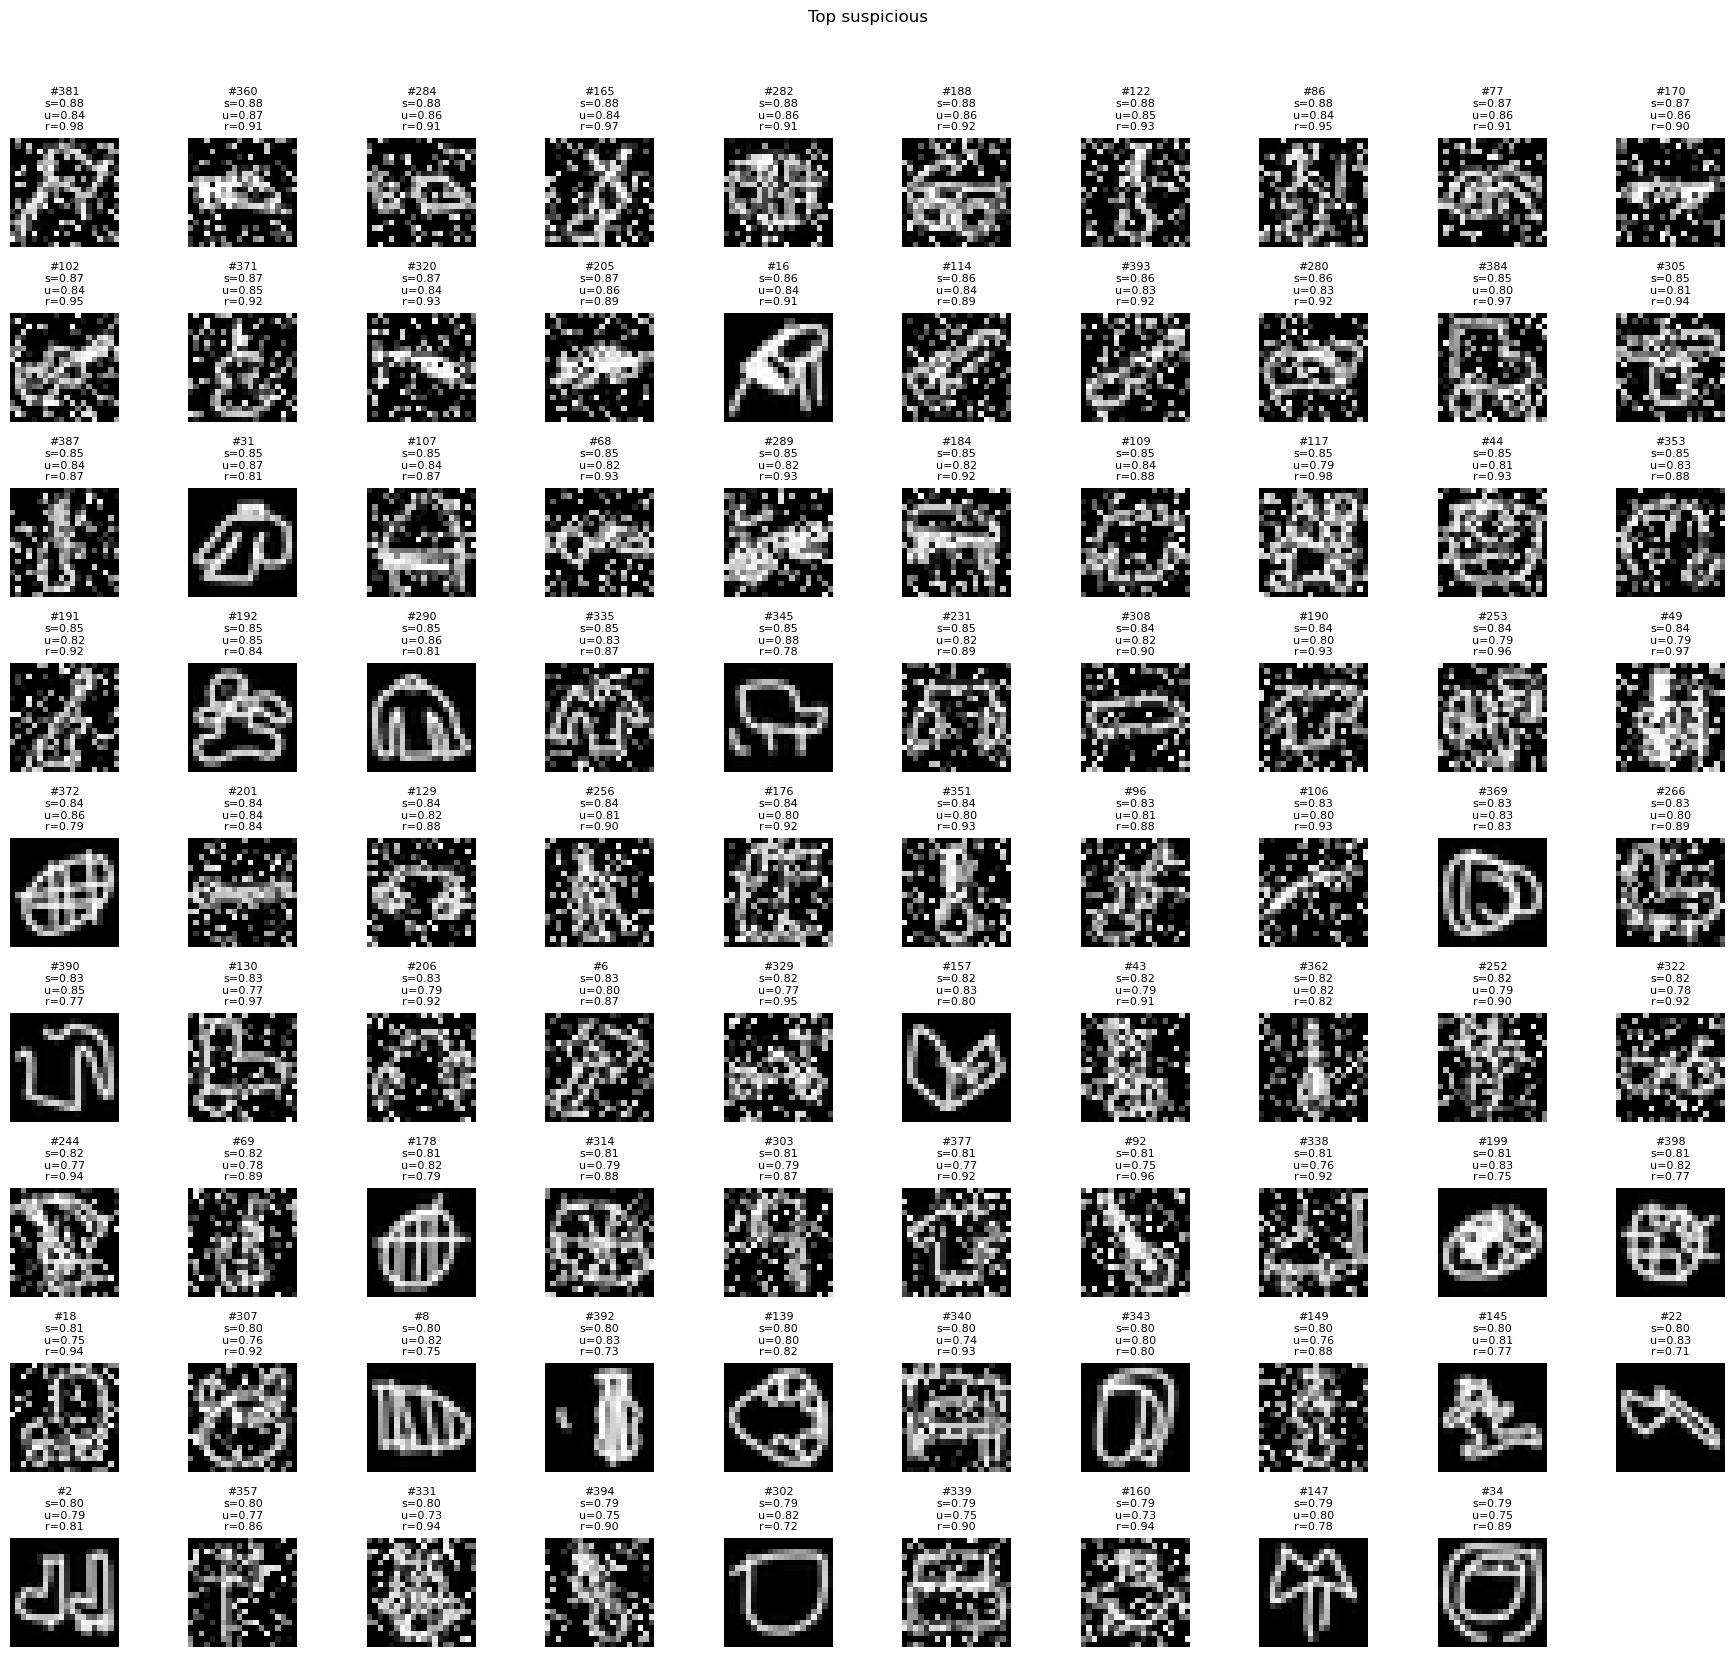

In [106]:
import math

top_idx = np.argsort(score)[::-1][:89]

cols = 10                               # velg kolonner
rows = math.ceil(len(top_idx) / cols)   # nok rader

plt.figure(figsize=(cols*1.8, rows*1.8))
for i, k in enumerate(top_idx, 1):
    plt.subplot(rows, cols, i)
    plt.imshow(Xc[k].reshape(20,20), cmap="gray", vmin=0, vmax=255)
    plt.title(f"#{k}\ns={score[k]:.2f}\nu={unc[k]:.2f}\nr={re_n[k]:.2f}", fontsize=8)
    plt.axis("off")
plt.suptitle("Top suspicious", y=1.02)
plt.tight_layout()
plt.show()
